
Examples of KNN with Graphs
– Classification: Iris
– Regression: California Housing


In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics.pairwise import cosine_similarity

from sklearn.datasets import load_iris, fetch_california_housing
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.metrics import (
    confusion_matrix,
    ConfusionMatrixDisplay,
    classification_report,
    mean_squared_error,
    r2_score,
)
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor, NearestNeighbors



# 1) CLASSIFICATION – IRIS

![Iris Flower Dataset](https://miro.medium.com/v2/resize:fit:1000/1*nfK3vGZkTa4GrO7yWpcS-Q.png)
Source = https://medium.com/@Locemarn/an%C3%A1lise-de-dados-explorat%C3%B3rios-iris-flower-dataset-611cb68fb78e

Fontes:

https://scikit-learn.org/1.6/modules/generated/sklearn.neighbors.KNeighborsClassifier.html

https://www.youtube.com/watch?v=DeAuVrhKw58

https://plotly.com/python/3d-scatter-plots/

In [ ]:

iris = load_iris()
X_iris, y_iris = load_iris(return_X_y=True)

In [ ]:
X_train_i, X_test_i, y_train_i, y_test_i = train_test_split(
    X_iris, y_iris, test_size=0.3, random_state=42, stratify=y_iris
)

In [ ]:
n_neighbors = 10
clf = KNeighborsClassifier(n_neighbors)
clf.fit(X_train_i, y_train_i)

KNeighborsClassifier(n_neighbors=10)

In [ ]:
y_pred = clf.predict(X_test_i)


In [ ]:
from sklearn.metrics import classification_report

print(classification_report(y_test_i, y_pred, target_names=iris.target_names))

              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      1.00      0.94        15
   virginica       1.00      0.87      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



In [ ]:
import plotly.express as px
df = px.data.iris()
fig = px.scatter_3d(df, x='sepal_length', y='sepal_width', z='petal_width', size_max=10,
    color='species',
    height=700,
    width=800,)
plt.tight_layout()
fig.show()

<Figure size 640x480 with 0 Axes>

In [ ]:
confusion_matrix(y_test_i, y_pred)


array([[15,  0,  0],
       [ 0, 15,  0],
       [ 0,  2, 13]])

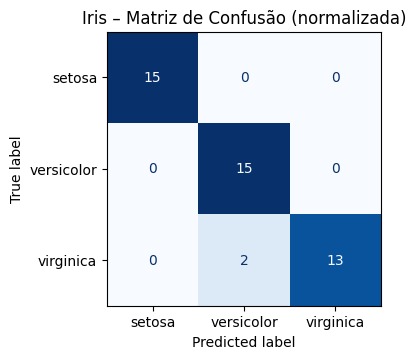

In [ ]:
cm = confusion_matrix(y_test_i, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=load_iris().target_names)

fig1, ax1 = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax1, cmap="Blues", colorbar=False)
ax1.set_title("Iris – Matriz de Confusão (normalizada)")
plt.tight_layout()


=== Classificação Iris ===
Melhor k: 14
              precision    recall  f1-score   support

      setosa       1.00      1.00      1.00        15
  versicolor       0.88      1.00      0.94        15
   virginica       1.00      0.87      0.93        15

    accuracy                           0.96        45
   macro avg       0.96      0.96      0.96        45
weighted avg       0.96      0.96      0.96        45



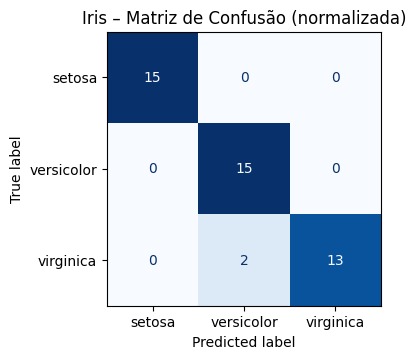

In [ ]:
# Pipeline: padronização + KNN
# Procura o melhor k
# Confusion Matrix
pipe_cls = Pipeline(
    [
        ("scaler", StandardScaler()),
        ("KNN", KNeighborsClassifier()),
    ]
)


param_grid_cls = {"KNN__n_neighbors": range(1, 16)}
grid_cls = GridSearchCV(pipe_cls, param_grid_cls, cv=5)
grid_cls.fit(X_train_i, y_train_i)

print("\n=== Classification Iris ===")
print("Melhor k:", grid_cls.best_params_["KNN__n_neighbors"])
print(classification_report(y_test_i, grid_cls.predict(X_test_i), target_names=load_iris().target_names))


cm = confusion_matrix(y_test_i, grid_cls.predict(X_test_i)) # , normalize="true"
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=load_iris().target_names)

fig1, ax1 = plt.subplots(figsize=(4, 4))
disp.plot(ax=ax1, cmap="Blues", colorbar=False)
ax1.set_title("Iris – Matriz de Confusão (normalizada)")
plt.tight_layout()





# 2) Simple Recommendation with User-Based Collaborative Filtering

In [ ]:
# Ratings matrix (users x movies)
# 0 means the user has not rated the movie
# Rows = Users | Columns = Movies
ratings = np.array([
    [5, 3, 0],  # Usuário 1
    [4, 0, 4],  # Usuário 2
    [1, 1, 5]   # Usuário 3
])


In [ ]:

# Function to predict the rating using KNN (user-based collaborative filtering)
def predict_rating(user_index, item_index, k=2):
    # Gets the vectors of all users except the current one
    user_ratings = ratings[:, item_index]
    similarities = []

    for other_user in range(ratings.shape[0]):
        if other_user != user_index and ratings[other_user, item_index] != 0:
             # Calculates the cosine similarity between the users
            sim = cosine_similarity(
                [ratings[user_index]],
                [ratings[other_user]]
            )[0][0]
            similarities.append((sim, ratings[other_user, item_index]))

    # Sorts by most similar
    similarities.sort(reverse=True)
    top_k = similarities[:k]

    if not top_k:
        return 0  # No information available to predict

    # Weighted average by the similarities
    num = sum(sim * rating for sim, rating in top_k)
    den = sum(abs(sim) for sim, _ in top_k)
    return num / den if den != 0 else 0

In [ ]:
# Predicting User 1's rating for Movie 3
predicted = predict_rating(user_index=0, item_index=2, k=2)
predicted.round(2)

np.float64(4.3)

# 3) Anomaly Detection with KNN

In [ ]:
# Data: 2D with an obvious outlier
X = np.array([
    [1, 2], [2, 3], [3, 2], [2, 1],
    [8, 8],  # <- outlier
])

In [ ]:
# Fits KNN model

k = 2
nbrs = NearestNeighbors(n_neighbors=k+1)  # +1 because the closest point to itself is itself
nbrs.fit(X)
distances, _ = nbrs.kneighbors(X)

# Ignores the first one (distance to itself)
mean_distances = distances[:, 1:].mean(axis=1)

In [ ]:
# Visualizes the points, highlighting the potential anomaly
plt.scatter(X[:, 0], X[:, 1], c=mean_distances, cmap='coolwarm', s=100)
plt.colorbar(label='Average distance to K neighbors')
plt.title("Anomaly Detection with KNN")
plt.show()